# Predicting Google Stock Price
### Shan Wang

### 15, October, 2022

[Data Source](https://www.nasdaq.com/market-activity/stocks/goog/historical)

循环神经网络 (RNN) 是一类神经网络，它们在序列数据（如时间序列或自然语言）建模方面非常强大。

## 1 Loading and Preprocessing the Data Set
We firstly load and preprocessing the training data.

In [5]:
import pandas as pd
train = pd.read_csv('Google_Stock_Price_Train.csv')

In [6]:
train.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,1,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,2,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,3,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,4,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,5,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [7]:
training_set=train.iloc[:,1:2].values

In [9]:
#Data Normalization
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

ValueError: could not convert string to float: '1/3/2012'

In [ ]:
training_set_scaled.shape

(1258, 1)

In [ ]:
import numpy as np

X_train=[]
y_train=[]
for i in range(60,1258):
    X_train.append(training_set_scaled[i-60:i,0]) #前60天的开盘价作为x
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#reshape it to (batche_size(#size of inputs),timesteps,input_dimension)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(1198, 60, 1)

## 2 Building a Recurrent Neural Network

In [ ]:
#利用`Sequential`模块搭建层叠的RNN模型,长短期记忆（Long short-term memory, LSTM）是一种特殊的RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout

model=Sequential()

#Add an LSTM layer with 100 units, expecting input of size `input_shape`.
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], 1)))

#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
model.add(Dropout(0.4))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(units=100))
model.add(Dropout(0.4))

# Add a Dense layer with 1 unit. Dense layer: fully connected layer
model.add(Dense(units=1))

#模型总结
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               8

`units`: dimensionality of the output space

默认情况下，RNN 层的输出为每个样本包含一个向量。此向量是与最后一个时间步骤相对应的 RNN 单元输出，包含关于整个输入序列的信息。此输出的形状为 `(batch_size, units)`。

如果您设置了 `return_sequences=True`，RNN 层还能返回每个样本的整个输出序列（每个样本的每个时间步骤一个向量）。此输出的形状为 `(batch_size, timesteps, units)`。

In [ ]:
#Model Compilation：通过调用 compile 方法配置该模型的学习流程
model.compile(optimizer='adam',loss='mean_squared_error')

## 3 Fitting the model

In [ ]:
model.fit(X_train,y_train,epochs=100,batch_size=60)

Epoch 1/100
20/20 [==============================] - 11s 329ms/step - loss: 0.1008
Epoch 2/100
20/20 [==============================] - 9s 468ms/step - loss: 0.0085
Epoch 3/100
20/20 [==============================] - 8s 389ms/step - loss: 0.0083
Epoch 4/100
20/20 [==============================] - 9s 452ms/step - loss: 0.0069
Epoch 5/100
20/20 [==============================] - 7s 353ms/step - loss: 0.0068
Epoch 6/100
20/20 [==============================] - 7s 357ms/step - loss: 0.0059
Epoch 7/100
20/20 [==============================] - 7s 347ms/step - loss: 0.0055
Epoch 8/100
20/20 [==============================] - 8s 417ms/step - loss: 0.0052
Epoch 9/100
20/20 [==============================] - 11s 550ms/step - loss: 0.0057
Epoch 10/100
20/20 [==============================] - 12s 583ms/step - loss: 0.0070
Epoch 11/100
20/20 [==============================] - 12s 635ms/step - loss: 0.0080
Epoch 12/100
20/20 [==============================] - 9s 468ms/step - loss: 0.0064
Epoch 13/

## 4 Model prediction
Loading and preprocessing the testing data.

In [ ]:
test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = test.iloc[:, 1:2].values
total_data=pd.concat([train['Open'],test['Open']],axis=0)

In [ ]:
inputs=total_data[len(train)-len(test)-60:].values #测试集第一天的60天前的数据 
inputs=inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
X_test=[]
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test.shape
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
#Predict the stock price
predicted_stock_price=model.predict(X_test)
predicted_stock_price=sc.inverse_transform(predicted_stock_price)

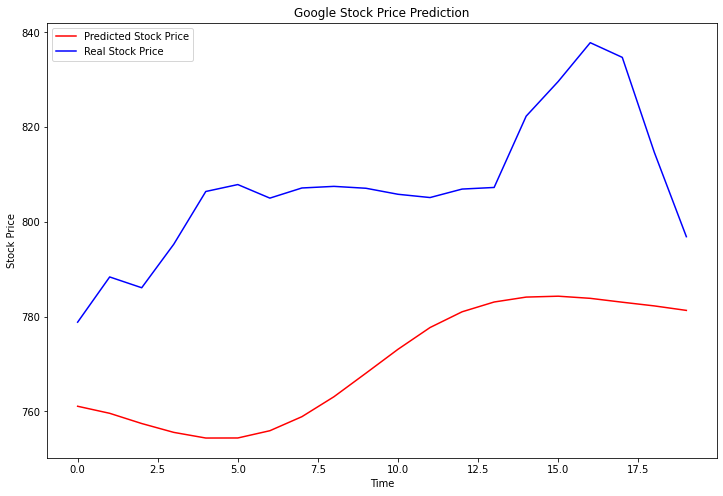

In [ ]:
#Visualization
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(predicted_stock_price,color='red',label='Predicted Stock Price')
plt.plot(real_stock_price,color='blue',label='Real Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()